(200, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ï»¿rank            200 non-null    int64 
 1   channel_info       200 non-null    object
 2   influence_score    200 non-null    int64 
 3   posts              200 non-null    object
 4   followers          200 non-null    object
 5   avg_likes          200 non-null    object
 6   60_day_eng_rate    200 non-null    object
 7   new_post_avg_like  200 non-null    object
 8   total_likes        200 non-null    object
 9   country            138 non-null    object
dtypes: int64(2), object(8)
memory usage: 15.8+ KB
None
   ï»¿rank channel_info  influence_score  posts followers avg_likes  \
0        1    cristiano               92   3.3k    475.8m      8.7m   
1        2  kyliejenner               91   6.9k    366.2m      8.3m   
2        3     leomessi               90  0.89k    3

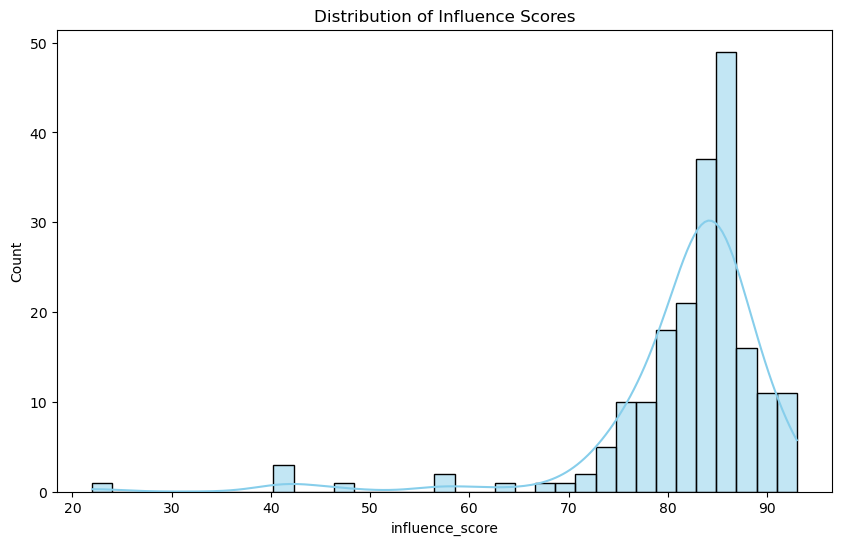

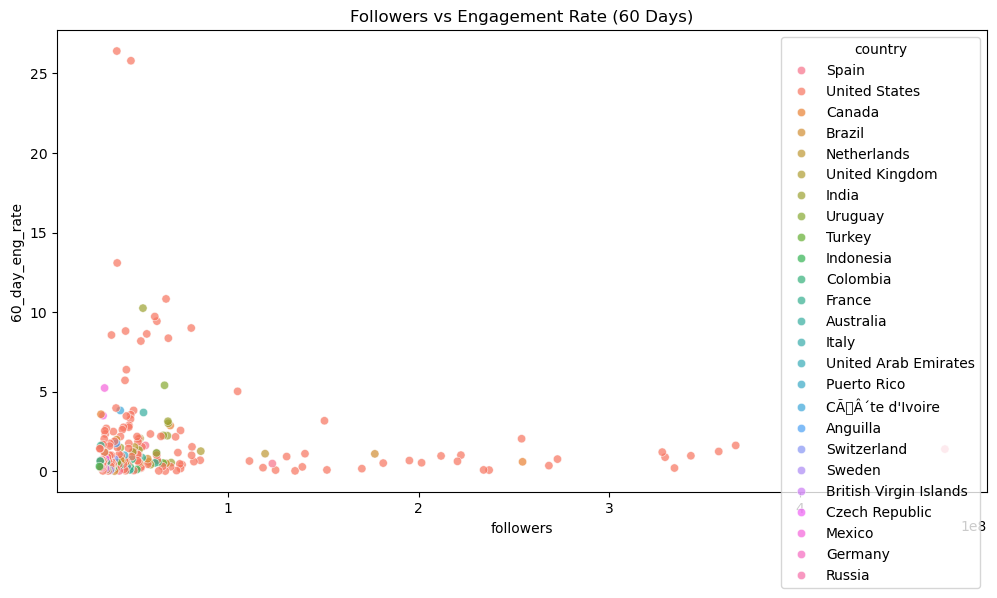

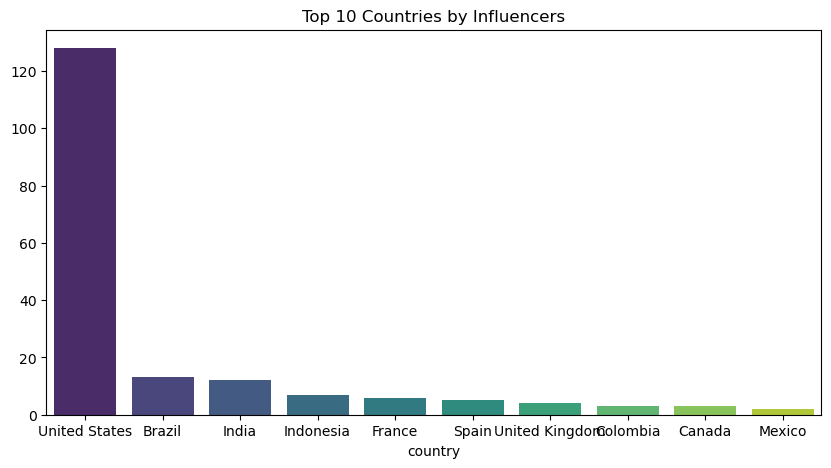

Regression Model Performance:
MSE: 171.57413
R2: -0.014814953920542884


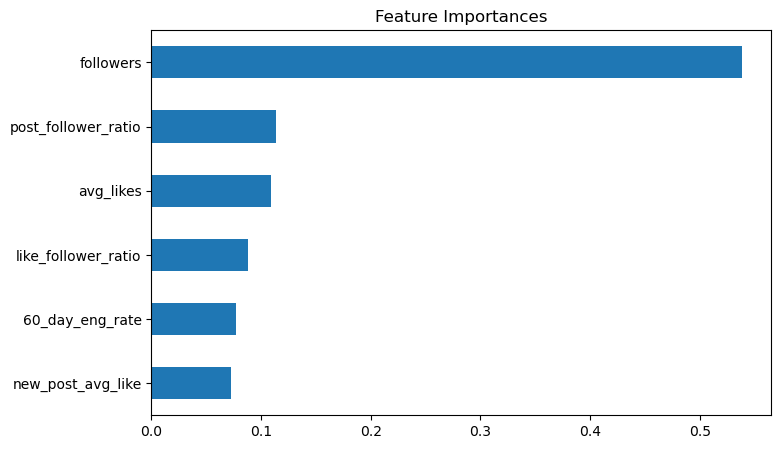


Classification Accuracy: 0.475
Classification Report:
               precision    recall  f1-score   support

        High       0.40      0.25      0.31         8
         Low       0.52      0.72      0.60        18
      Medium       0.40      0.29      0.33        14

    accuracy                           0.47        40
   macro avg       0.44      0.42      0.42        40
weighted avg       0.45      0.47      0.45        40



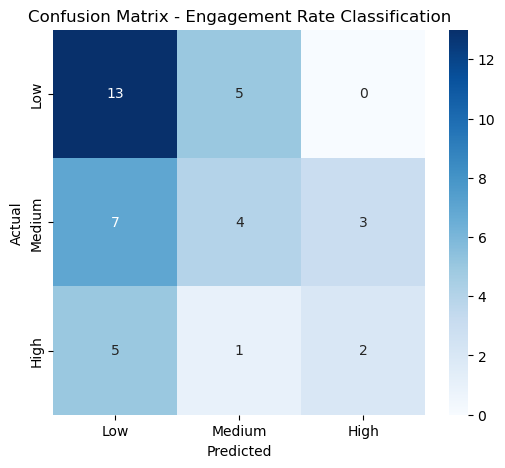

In [5]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, confusion_matrix

# Step 2: Load Dataset
df = pd.read_csv(r"C:\Users\OWNER\OneDrive\Documents\top_insta_influencers_data.csv", encoding='latin1')

# Quick Inspection
print(df.shape)
print(df.info())
print(df.head())

# Step 3: Data Cleaning
# Replace shorthand like 'm', 'k', 'b' with numeric values
replace = {'b': 'e9', 'm': 'e6', 'k': 'e3', '%': ''}
convert_cols = ['total_likes','posts','followers','avg_likes','60_day_eng_rate','new_post_avg_like']

df[convert_cols] = df[convert_cols].replace(replace, regex=True).astype(float)

# Handle missing values
df.drop_duplicates(inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)
df['country'].fillna(df['country'].mode()[0], inplace=True)

print("\nAfter Cleaning:")
print(df.info())

# Step 4: Exploratory Data Analysis (EDA)
plt.figure(figsize=(10,6))
sns.histplot(df['influence_score'], kde=True, color="skyblue")
plt.title("Distribution of Influence Scores")
plt.show()

plt.figure(figsize=(12,6))
sns.scatterplot(x="followers", y="60_day_eng_rate", hue="country", data=df, alpha=0.7)
plt.title("Followers vs Engagement Rate (60 Days)")
plt.show()

top_countries = df['country'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.index, y=top_countries.values, palette="viridis")
plt.title("Top 10 Countries by Influencers")
plt.show()

# Step 5: Feature Engineering
df['like_follower_ratio'] = df['total_likes'] / df['followers']
df['post_follower_ratio'] = df['posts'] / df['followers']
df['avg_likes_ratio'] = df['avg_likes'] / df['followers']

# Step 6: Regression Model (Predict Influence Score)
X = df[['followers','avg_likes','60_day_eng_rate','new_post_avg_like','like_follower_ratio','post_follower_ratio']]
y = df['influence_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

reg_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_model.fit(X_train_scaled, y_train)
y_pred = reg_model.predict(X_test_scaled)

print("Regression Model Performance:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

# Feature Importance
feat_imp = pd.Series(reg_model.feature_importances_, index=X.columns).sort_values()
feat_imp.plot(kind="barh", title="Feature Importances", figsize=(8,5))
plt.show()

# Step 7: Classification (Engagement Rate Binning)
bins = [0, 1, 3, df['60_day_eng_rate'].max()]
labels = ['Low', 'Medium', 'High']
df['engagement_rate_class'] = pd.cut(df['60_day_eng_rate'], bins=bins, labels=labels)

encoder = LabelEncoder()
df['country_encoded'] = encoder.fit_transform(df['country'])

X_cls = df[['followers','influence_score','country_encoded']]
y_cls = df['engagement_rate_class']

X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred_cls = clf.predict(X_test)

print("\nClassification Accuracy:", accuracy_score(y_test, y_pred_cls))
print("Classification Report:\n", classification_report(y_test, y_pred_cls))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cls, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Engagement Rate Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
